
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

#pcam, pcam_info = tfds.load('patch_camelyon', shuffle_files=True, with_info=True)
pcam, pcam_info = tfds.load("patch_camelyon", data_dir='/content/drive/My Drive/Colab Notebooks',download=False, with_info=True) 

In [0]:
#print(pcam)

In [0]:
#model = tf.keras.models.load_model('./patchcamelyon.hf5')

In [5]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import TensorFlow and relevant Keras classes to setup the model
#import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(rate=0.3)(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model2 = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.007, momentum=0.1, decay=0.0, nesterov=True)
model2.compile(optimizer=sgd_opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
#model.summary()

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [9]:
hist2 = model2.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=50, steps_per_epoch=4096, validation_steps=256)

Epoch 1/50
4096/4096 - 267s - loss: 0.4471 - accuracy: 0.8030 - val_loss: 0.6408 - val_accuracy: 0.6955
Epoch 2/50
4096/4096 - 264s - loss: 0.3823 - accuracy: 0.8361 - val_loss: 0.6345 - val_accuracy: 0.7247
Epoch 3/50
4096/4096 - 258s - loss: 0.3458 - accuracy: 0.8537 - val_loss: 0.7921 - val_accuracy: 0.6955
Epoch 4/50
4096/4096 - 263s - loss: 0.3214 - accuracy: 0.8649 - val_loss: 0.5287 - val_accuracy: 0.7880
Epoch 5/50
4096/4096 - 261s - loss: 0.3039 - accuracy: 0.8732 - val_loss: 0.5220 - val_accuracy: 0.7776
Epoch 6/50
4096/4096 - 260s - loss: 0.2886 - accuracy: 0.8801 - val_loss: 1.3197 - val_accuracy: 0.6588
Epoch 7/50
4096/4096 - 260s - loss: 0.2786 - accuracy: 0.8856 - val_loss: 0.9192 - val_accuracy: 0.7368
Epoch 8/50
4096/4096 - 263s - loss: 0.2697 - accuracy: 0.8900 - val_loss: 0.8968 - val_accuracy: 0.7241
Epoch 9/50
4096/4096 - 263s - loss: 0.2616 - accuracy: 0.8936 - val_loss: 0.9282 - val_accuracy: 0.7329
Epoch 10/50
4096/4096 - 261s - loss: 0.2532 - accuracy: 0.8979 -

In [10]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model2.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.7538


In [0]:
#model2.save("pcam2")

In [0]:
#model3 = tf.keras.models.load_model('pcam2')

In [0]:
#e3 = model3.evaluate(test_pipeline, steps=128, verbose=0)

In [0]:
#print(e3)

In [0]:
#print(test_pipeline)

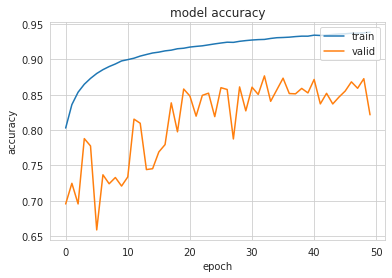

In [16]:
# summarize history for loss
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

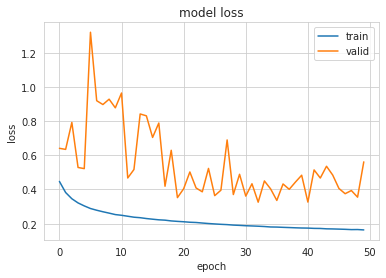

In [17]:
# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [18]:

#Predict on test set
predictions_NN_prob = model2.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output



y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.246246337890625


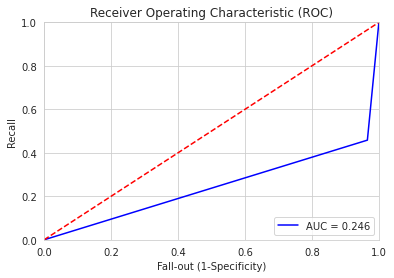

In [19]:
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_01)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

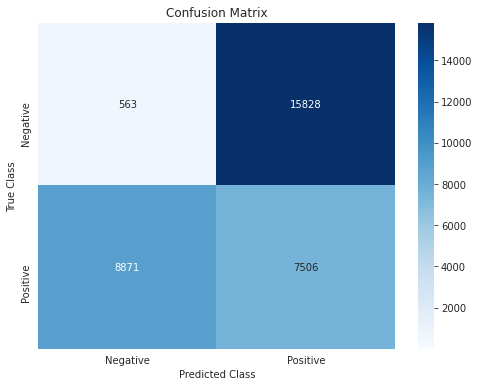

In [20]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()